In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

#from tqdm import tqdm
from tqdm.notebook import tqdm
import time

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import models
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch

from IPython.display import display, HTML
#from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from archs import ResEmoteNetPT, DDAMPT, MixedFeatureNetPT
import pandas as pd

In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PyTorch version: 2.6.0+cu126
CUDA is available


In [4]:
def ResNet(num_classes = 8, ):
    net = torch.hub.load("pytorch/vision", "resnet50")#, weights="IMAGENET1K_V2")
    final_in_ftrs = net.fc.in_features
    net.fc = nn.Linear(final_in_ftrs, num_classes)
    return net

In [5]:
BASE_PATH = r''
Model_Name = 'ResNet'
Dataset = 'FERPlusNew'
SIZE_IMAGE = 128
BATCH_SIZE = 64

if Dataset=='FERPlusNew':
    DATA_PATH = BASE_PATH + 'data/FERPlusNew'
    WEIGHT_PATH = BASE_PATH + 'weights/FERPlusNew'
    NUM_CLASSES = 8
elif Dataset=='FER13New':
    DATA_PATH = BASE_PATH + 'data/FER13New'
    WEIGHT_PATH = BASE_PATH + 'weights/FER13New/' + Model_Name
    NUM_CLASSES = 7
else:
    raise 

In [6]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# If using CUDA (GPU), set the seed for all GPU devices
torch.cuda.manual_seed_all(seed)
eps = sys.float_info.epsilon

In [7]:
class AttentionLoss(nn.Module):
    def __init__(self, ):
        super(AttentionLoss, self).__init__()
    
    def forward(self, x):
        num_head = len(x)
        loss = 0
        cnt = 0
        if num_head > 1:
            for i in range(num_head-1):
                for j in range(i+1, num_head):
                    mse = F.mse_loss(x[i], x[j])
                    cnt = cnt+1
                    loss = loss+mse
            loss = cnt/(loss + eps)
        else:
            loss = 0
        return loss

In [8]:
train_path = DATA_PATH + r'\train'
val_path = DATA_PATH + r'\val'
test_path = DATA_PATH + r'\test'

# train_transform = transforms.Compose([
#     transforms.Resize((SIZE_IMAGE, SIZE_IMAGE)),
#     transforms.Grayscale(num_output_channels=3),
#     transforms.RandomRotation(30),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.1),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_transform = transforms.Compose([
    transforms.Resize((SIZE_IMAGE, SIZE_IMAGE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),        
    transforms.RandomApply([
        transforms.RandomRotation(10),
        transforms.RandomCrop(SIZE_IMAGE, padding=int(16*(SIZE_IMAGE/112)))], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(scale=(0.02,0.25))])

# train_transform = transforms.Compose([
#     transforms.Resize((SIZE_IMAGE, SIZE_IMAGE)),
#     transforms.ToTensor()])

val_transform = transforms.Compose([
    transforms.Resize((SIZE_IMAGE, SIZE_IMAGE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize((SIZE_IMAGE, SIZE_IMAGE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Load datasets using ImageFolder (assuming images are organized in subfolders by class)
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

# Create data loaders
#sampler=ImbalancedDatasetSampler(train_dataset),
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)#, num_workers=8
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Example to check the data loaders:
print("Training DataLoader:", len(train_loader.dataset))
print("Validation DataLoader:", len(val_loader.dataset))
print("Test DataLoader:", len(test_loader.dataset))

Training DataLoader: 25543
Validation DataLoader: 2843
Test DataLoader: 7099


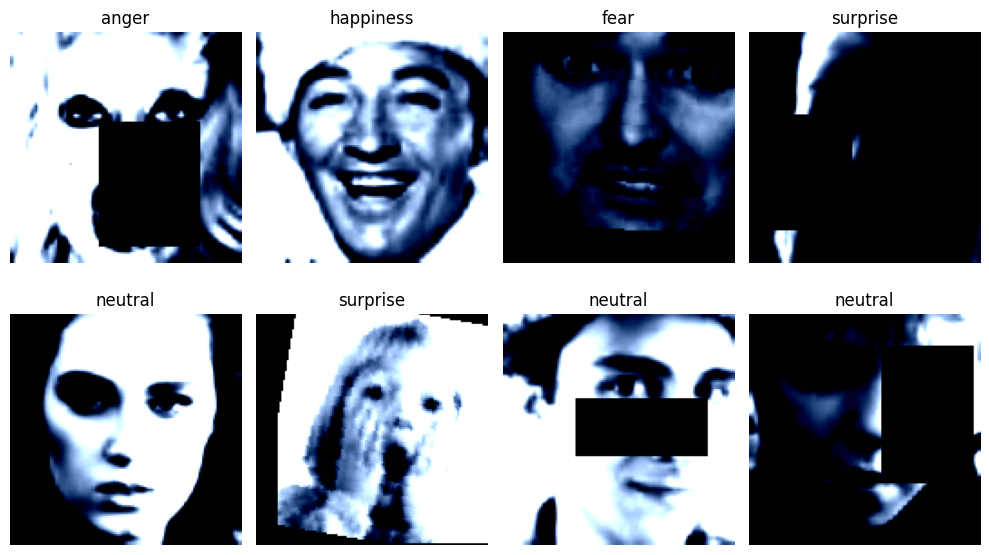

In [9]:
# Get a batch of images and labels from the DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# If you need to move the images from GPU to CPU, do this
# images = images.cpu()

# Convert images to numpy arrays and transpose from (C, H, W) to (H, W, C)
images = images.numpy().transpose((0, 2, 3, 1))
images = np.clip(images, 0, 1)

# Get class names (assuming you have them stored)
class_names = train_loader.dataset.classes

# Create a figure with 8 subplots
fig, axes = plt.subplots(2, 4, figsize=(10, 6))

# Flatten the axes array to make it easier to iterate over
axes = axes.ravel()

# Loop through the first 8 images in the batch and display them
for i in range(8):
    axes[i].imshow(images[i])  # Show the image
    axes[i].axis('off')  # Hide the axes
    label_idx = labels[i].item()  # Since labels are now integer-encoded, we can directly access the class index
    label_name = class_names[label_idx]  # Map the numeric label to the class name
    axes[i].set_title(f'{label_name}')  # Display the class name as the label

plt.tight_layout()
plt.show()

In [10]:
def compute_confusion_matrix(model, test_loader, device):
    # Move the model to the appropriate device (GPU or CPU)
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    # Create empty lists to store the true labels and predicted labels
    test_labels = []
    test_pred_labels = []

    # Loop through the test set
    with torch.no_grad():  # No need to compute gradients for inference
        for batch_images, batch_labels in test_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

            # Get predictions
            outputs = model(batch_images)
            #outputs = outputs[0] # DDMN
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability

            # Append the true and predicted labels
            test_labels.append(batch_labels.cpu().numpy())  # Move labels to CPU and store them
            test_pred_labels.append(predicted.cpu().numpy())  # Move predictions to CPU and store them

    # Flatten the lists
    test_labels = np.concatenate(test_labels)
    test_pred_labels = np.concatenate(test_pred_labels)

    # Create confusion matrix
    confusion_mtx = confusion_matrix(test_labels, test_pred_labels)

    # Assuming you have a dictionary mapping class indices to class names
    class_names = test_loader.dataset.classes  # Adjust according to your dataset

    return confusion_mtx, class_names

In [ ]:
# Custom function to track learning rate history
class LearningRateHistory:
    def __init__(self):
        self.lr_history = []

    def on_epoch_end(self, optimizer):
        self.lr_history.append(optimizer.param_groups[0]['lr'])

# Helper functions for plotting (same as before)
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    plt.show()

def plot_lr_history(lr_history, model, test_loader, device):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    lr_history.insert(0, lr_history[0]) 

    plt.step(np.arange(len(lr_history)), lr_history, where='post')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Log(Learning Rate)')
    plt.title('Learning Rate vs Epochs')
    #plt.grid(True)

    plt.subplot(1, 2, 2)
    confusion_mtx, class_names = compute_confusion_matrix(model, test_loader, device)
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    
    plt.show()

In [ ]:
def train_FER(model, learning_rate, num_epochs, batch_size, train_loader, val_loader, test_loader, device, verbose=False, patience=100):
    
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.enabled = True
    
    model.to(device)

    # Set up the learning rate scheduler (Exponential Decay)
    initial_learning_rate = learning_rate  # Save the initial learning rate
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
    # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    criterion = nn.CrossEntropyLoss()  # Categorical crossentropy equivalent in PyTorch
    criterion_at = AttentionLoss()

    lr_history_callback = LearningRateHistory()
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    learning_rate_history = []

    best_val_acc = 0
    patience_counter = 0

    # Initialize validation metrics to desired values
    avg_val_loss = float('inf') 
    val_accuracy = 0.0 

    # Create a single progress bar for the entire training
    pbar = tqdm(total=num_epochs, desc="Training Progress")

    for epoch in range(num_epochs):
        start_time = time.time()  # Start timing the epoch

        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Track the number of batches
        num_batches = len(train_loader)

        # # Reset learning rate after epoch 40
        # if epoch%40==0:
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = initial_learning_rate  # Reset learning rate to initial value
        
        # Loop over the batches
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            #outputs,feat,heads = model(images)
            #loss = criterion(outputs,labels)  + 0.1*criterion_at(heads)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Calculate average loss and accuracy for the current batch
            avg_train_loss = running_train_loss / (i+1)
            train_accuracy = 100 * correct_train / total_train

            # Update the progress bar description during training
            pbar.set_postfix(
                train_loss=f"{avg_train_loss:.4f}",
                train_acc=f"{train_accuracy:.2f}%",
                val_loss=f"{avg_val_loss:.4f}",
                val_acc=f"{val_accuracy:.2f}%")

        # After finishing the training loop for the epoch
        avg_train_loss = running_train_loss / num_batches
        train_losses.append(avg_train_loss)
        train_accuracies.append(100 * correct_train / total_train)

        # Validation loop
        model.eval()  # Switch to evaluation mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                #outputs,feat,heads = model(images)
                #loss = criterion(outputs,labels)  + 0.1*criterion_at(heads)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        # Update the progress bar with validation metrics after the validation loop
        pbar.set_postfix(
            train_loss=f"{avg_train_loss:.4f}",
            train_acc=f"{train_accuracy:.2f}%",
            val_loss=f"{avg_val_loss:.4f}",
            val_acc=f"{val_accuracy:.2f}%")
        
        # Store validation results
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Update learning rate schedule
        lr_scheduler.step()
        lr_history_callback.on_epoch_end(optimizer)

        # Early Stopping and model saving on best validation accuracy
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), WEIGHT_PATH + r'\best_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter > patience:
            #print("Stopping early due to lack of improvement in validation accuracy.")
            break

        # Update the progress bar after the epoch is done
        pbar.update(1)

    # Close the progress bar at the end of training
    pbar.close()

    # Store history in a dataframe
    history_df = pd.DataFrame({
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies,})

    # Optionally plot the training history
    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

    # Optionally plot the learning rate history
    learning_rate_history = lr_history_callback.lr_history
    plot_lr_history(learning_rate_history, model, test_loader, device)

    # Test evaluation after training
    model.load_state_dict(torch.load(WEIGHT_PATH + r'\best_model.pth', weights_only=True))
    
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            #outputs,feat,heads = model(images)
            #loss = criterion(outputs,labels)  + 0.1*criterion_at(heads)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    #print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Return the history dataframe with test results
    history_df['test_loss'] = [avg_test_loss] * len(history_df)
    history_df['test_accuracy'] = [test_accuracy] * len(history_df)

    return history_df

Training Progress:   0%|          | 0/120 [00:00<?, ?it/s]

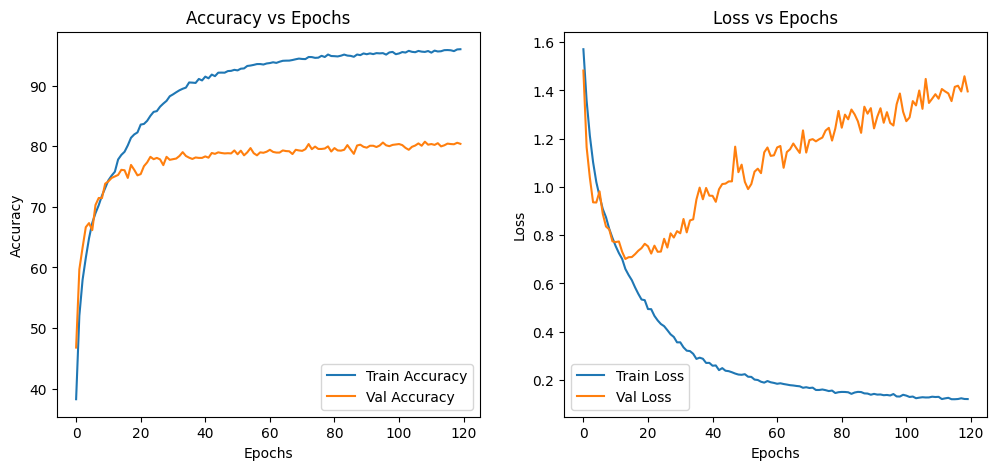

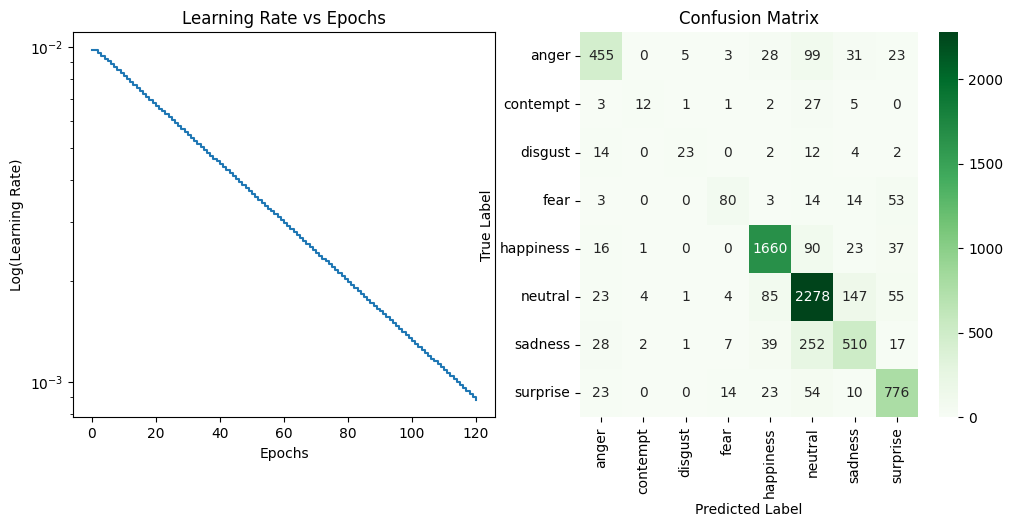

In [ ]:
model = ResEmoteNetPT.ResEmoteNet(num_classes=NUM_CLASSES)
#model = ResNet(num_classes=NUM_CLASSES)
#pretrained_address = os.path.join('./weights/FERPlusNew/DDAMPT', "best_model.pth")
#model = DDAMPT.DDAMNet(num_class=NUM_CLASSES, num_head=2, pretrained=False, pretrained_address=pretrained_address)
model.to(device)

history_df = train_FER(
    model=model,
    learning_rate=1e-2, 
    num_epochs=120,
    batch_size=BATCH_SIZE,
    train_loader=train_loader, 
    val_loader=val_loader, 
    test_loader=test_loader, 
    device=device, 
    verbose=True) # learning_rate=2e-2, num_epochs=60*3, batch_size=32

In [14]:
pd.options.display.float_format = "{:,.2f}".format
display(pd.DataFrame({'result': history_df.iloc[-1]}).T)

,train_loss,val_loss,train_accuracy,val_accuracy,test_loss,test_accuracy
result,0.12,1.40,96.02,80.41,1.24,81.18
